In [1]:
from pathlib import Path
import sys

# Set project root directory as path
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))

In [2]:
import torch
import pandas as pd
import segmentation_models_pytorch as smp
from augment import BasicAugment
from dataset import SlideTileDataset, read_tile_metadata
from metrics import get_segmentation_metrics
from utils import set_seed
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

/home/arif/Playground/code-tseg/tseg/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
@torch.no_grad()
def get_predictions(model, loader, device):
    model.eval()
    all_outputs = []
    all_masks = []

    for batch in loader:
        images = batch["image"].to(device)
        masks = batch["mask"].to(device)

        with torch.autocast(device_type=device.type):
            outputs = model(images)

        all_outputs.append(outputs.cpu())
        all_masks.append(masks.cpu())

    return torch.cat(all_outputs), torch.cat(all_masks)

In [4]:
source = Path("~/Playground/tiles/dataset-combined-512-256-jpg").expanduser()
model_path = Path("../../experiments/tumorseg_20250616020201/checkpoints/best")

In [5]:
set_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

metadata_df = read_tile_metadata(source / "metadata")
split_df = metadata_df[metadata_df["split"] != "train"]

dataset = SlideTileDataset(
    source=source,
    df=split_df,
    transform=BasicAugment(256),
    img_size=256,
)

loader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4)
model = smp.from_pretrained(model_path).to(device)
outputs, masks = get_predictions(model, loader, device)

thresholds = torch.arange(0.1, 0.95, 0.05)
results = []

for conf in thresholds:
    metrics = get_segmentation_metrics(outputs, masks, conf.item())
    results.append({"confidence": conf.item(), **metrics})

df = pd.DataFrame(results)
df["avg"] = df[df.columns].mean(axis=1)
print("Confidences:")
df

Loading weights from local directory
Confidences:


,confidence,dice,iou,precision,recall,avg
0,0.10,0.715265,0.580222,0.621696,0.901774,0.583791
1,0.15,0.730219,0.597339,0.659823,0.868988,0.601274
2,0.20,0.737238,0.605742,0.688938,0.839962,0.614376
3,0.25,0.740124,0.609514,0.714808,0.811614,0.625212
4,0.30,0.738966,0.608932,0.740942,0.779845,0.633737
5,0.35,0.733204,0.603155,0.766502,0.744446,0.639461
6,0.40,0.722998,0.592439,0.790900,0.707425,0.642752
7,0.45,0.708637,0.577220,0.812584,0.669550,0.643598
8,0.50,0.689013,0.556285,0.832977,0.628688,0.641393
9,0.55,0.661206,0.526957,0.856924,0.580441,0.635106


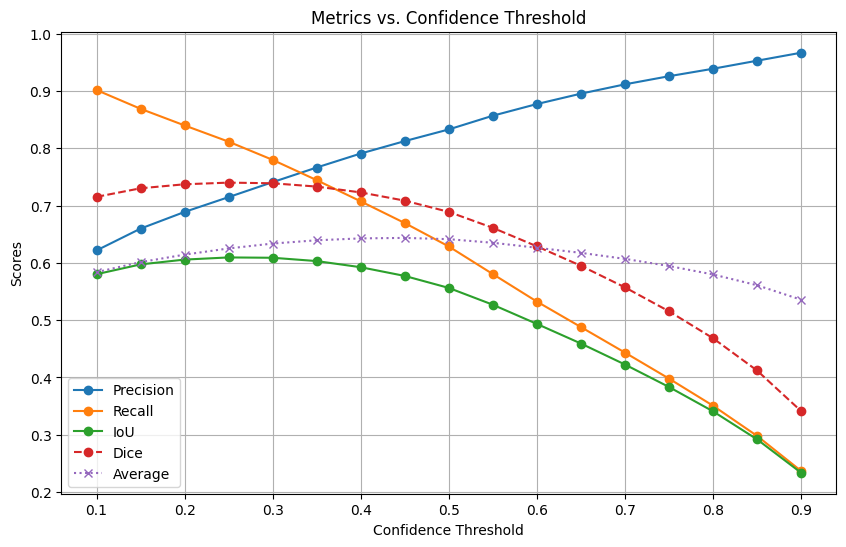

In [6]:
plt.figure(figsize=(10, 6))

plt.plot(df["confidence"], df["precision"], "o-", label="Precision")
plt.plot(df["confidence"], df["recall"], "o-", label="Recall")
plt.plot(df["confidence"], df["iou"], "o-", label="IoU")
plt.plot(df["confidence"], df["dice"], "o--", label="Dice")
plt.plot(df["confidence"], df["avg"], "x:", label="Average")

plt.title("Metrics vs. Confidence Threshold")
plt.xlabel("Confidence Threshold")
plt.ylabel("Scores")
plt.legend()
plt.grid(True)
plt.legend()
plt.show()